<a href="https://colab.research.google.com/github/GitanDas/Corrosion-Detection-Model/blob/main/Corrosion_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Required Libraries

In [1]:
# Install requirements
!pip install opencv-python==4.5.3.56
# !pip install Pillow==8.3.2
!pip install timm==0.4.12
!pip install python-multipart==0.0.5
!pip install uvicorn==0.15.0
!pip install pyngrok
!pip install nest-asyncio

Defaulting to user installation because normal site-packages is not writeable
  Using cached opencv-python-4.5.3.56.tar.gz (89.2 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'error'


  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 2
  ╰─> [133 lines of output]
      Ignoring numpy: markers 'python_version == "3.6" and platform_machine != "aarch64" and platform_machine != "arm64"' don't match your environment
      Ignoring numpy: markers 'python_version >= "3.6" and sys_platform == "linux" and platform_machine == "aarch64"' don't match your environment
      Ignoring numpy: markers 'python_version >= "3.6" and sys_platform == "darwin" and platform_machine == "arm64"' don't match your environment
      Ignoring numpy: markers 'python_version == "3.7" and platform_machine != "aarch64" and platform_machine != "arm64"' don't match your environment
      Ignoring numpy: markers 'python_version == "3.8" and platform_machine != "aarch64" and platform_machine != "arm64"' don't match your environment
        Using cached setuptools-80.9.0-py3-none-any.whl.metadata (6.6 kB)
        Using cache

Defaulting to user installation because normal site-packages is not writeable
  Using cached timm-0.4.12-py3-none-any.whl.metadata (30 kB)
Using cached timm-0.4.12-py3-none-any.whl (376 kB)
Defaulting to user installation because normal site-packages is not writeable
  Using cached python-multipart-0.0.5.tar.gz (32 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for python-multipart: filename=python_multipart-0.0.5-py3-none-any.whl size=31748 sha256=557d4b9876ab6bd1b092a93dfb1bb5df22c39d5cdb58c7fd8761a20463eb3751
  Stored in directory: c:\users\hp2\appdata\local\pip\cache\wheels\b5\2d\66\d2594aaa5dd65f5f5abf479b67f828d040ad7bbbb9a9afba96
Successfully built python-multipart
Defaulting to us

In [3]:
DATA_DIR = './data'  # This is relative to your script location


In [4]:
import torchvision
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torchvision.transforms import ToTensor

In [5]:
transformations_exp = transforms.Compose([
    transforms.Resize((256,256)),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225]),
  ])

In [13]:
import os

train_path = os.path.join("data", "train")
for category in ["corrosion", "no_corrosion"]:
    category_path = os.path.join(train_path, category)
    images = os.listdir(category_path)
    print(f"{category}: {len(images)} images")


corrosion: 52 images
no_corrosion: 28 images


In [14]:
test_size = int(0.2 * len(dataset))  # 20% of total images for testing
train_size = len(dataset) - test_size

train_ds, test_ds = random_split(dataset, [train_size, test_size])
len(train_ds), len(test_ds)


(64, 16)

In [15]:
from torch.utils.data.dataloader import DataLoader
batch_size = 16  # or even 8


In [16]:
train_dl = DataLoader(train_ds,
                      batch_size,
                      shuffle = True,
                      pin_memory = True)
test_dl = DataLoader(test_ds,
                     batch_size*2,
                     shuffle=False,
                     pin_memory = True)

In [17]:
from torchvision.utils import make_grid
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize = (12,6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 10).permute(1,2,0))
        break

C:\Users\hp2\AppData\Roaming\Python\Python313\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


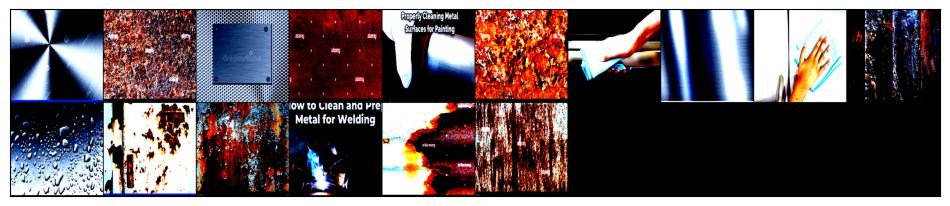

In [18]:
show_batch(train_dl)

In [19]:
import torch.nn as nn
import torch.nn.functional as F

In [20]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [21]:
class Corrosion_Detection(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            # imput : 3 x 224 x 224
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            # output : 32 x 224 x 224
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 112 x 112

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 56 x 56

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 28 x 28

            nn.Flatten(),
            nn.Linear(256*28*28, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 2))

    def forward(self, xb):
        return self.network(xb)

In [22]:
model = Corrosion_Detection()
model

Corrosion_Detection(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=200704, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(i

In [23]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [24]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [25]:
train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(test_dl, device)
model = model.to(device)

In [26]:
@torch.no_grad()# The @ does not allow tracking of gradients
def evaluate(model, test_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in test_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, test_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Testing phase
        result = evaluate(model, test_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [27]:
model = to_device(Corrosion_Detection(), device)

In [28]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.0001

In [29]:
history = fit(num_epochs, lr, model, train_dl, test_dl, opt_func)

Epoch [0], train_loss: 0.6598, val_loss: 0.6488, val_acc: 0.6250
Epoch [1], train_loss: 0.6667, val_loss: 0.6083, val_acc: 0.6250
Epoch [2], train_loss: 0.5877, val_loss: 0.5626, val_acc: 0.6250
Epoch [3], train_loss: 0.4886, val_loss: 0.4207, val_acc: 0.7500
Epoch [4], train_loss: 0.3597, val_loss: 0.3805, val_acc: 0.9375
Epoch [5], train_loss: 0.3009, val_loss: 0.2376, val_acc: 0.9375
Epoch [6], train_loss: 0.1769, val_loss: 0.0988, val_acc: 1.0000
Epoch [7], train_loss: 0.0874, val_loss: 0.0599, val_acc: 1.0000
Epoch [8], train_loss: 0.0353, val_loss: 0.0776, val_acc: 1.0000
Epoch [9], train_loss: 0.0303, val_loss: 0.0425, val_acc: 1.0000


In [30]:
def plot_accuracies(history):
  accuracies = [x['val_acc'] for x in history]
  plt.plot(accuracies, '-x')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.title('Accuracy vs No. of Epochs');

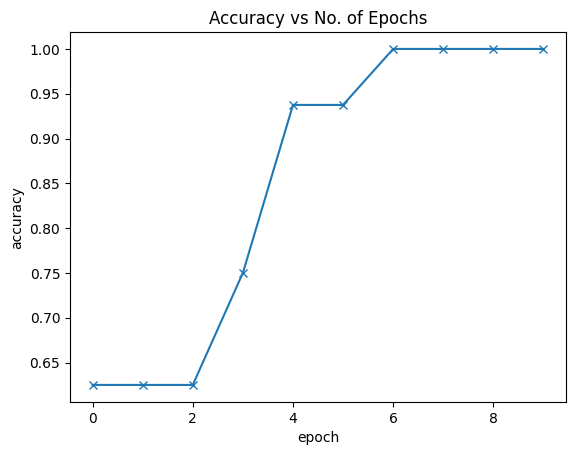

In [31]:
plot_accuracies(history)

In [32]:
def plot_losses(history):
  train_losses = [x.get('train_loss') for x in history]
  val_losses = [x.get('val_loss') for x in history]
  plt.plot(val_losses, '-rx')
  plt.plot(train_losses, '-bx')
  plt.xlabel('epoch')
  plt.ylabel(['Validation', 'Training'])
  plt.title('Loss vs NO. of Epochs')

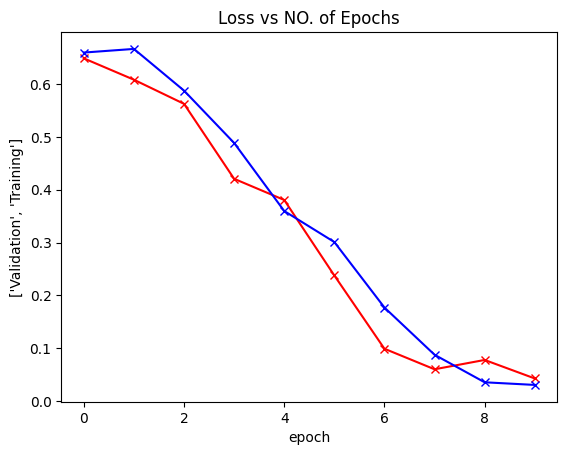

In [33]:
plot_losses(history)

# Save and Test

In [35]:
torch.save(model.state_dict(), 'Corrosion_Detection.pth')


In [36]:
import torch
import cv2
import torchvision.transforms as transforms

In [37]:
def predict_single(image, model):
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    # _, preds = torch.max(yb, dim = 1);
    # print(preds[0].item())
    # print("Prediction: ", prediction[0].item())
    prediction = preds[0]
    a = prediction[0].item()
    b = prediction[1].item()
    print(a, b);
    if a>b :
        print("Corrosion")
    else:
        print("No Corrosion")
    plt.imshow(image.cpu().permute(1, 2, 0))

In [39]:
# path = '/content/drive/My Drive/Corrosion_Detection.pth'  ← ❌ This is for Google Colab
path = 'Corrosion_Detection.pth'  # ✅ If it's in your current working directory

# Or give the full path
# path = 'C:/Users/hp2/OneDrive/Desktop/aiml/Assignment_13/Corrosion_Detection.pth'

model = Corrosion_Detection()
model.load_state_dict(torch.load(path, map_location='cpu'))  # map_location helps if you saved on GPU
model = to_device(model, device)
model.eval()



Corrosion_Detection(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=200704, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(i

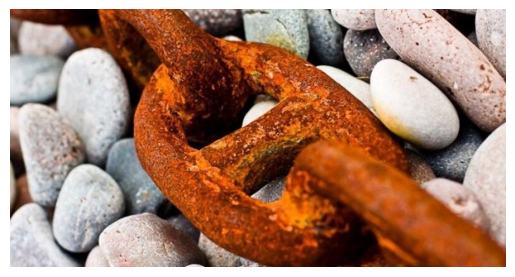

Transformed tensor shape: torch.Size([1, 3, 224, 224])


In [42]:
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms
import torch

# Try reading the image (make sure the path is correct)
image = cv2.imread('image.png')  # No /content here if local
if image is None:
    raise FileNotFoundError("Image not found. Check the file path!")

# Convert from BGR to RGB for correct color display in matplotlib
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.axis('off')
plt.show()

# Save a copy for later display
og_image = image.copy()

# Define transformation
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert NumPy image to PIL
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Apply transformation
tensor = transform(og_image).unsqueeze(0)  # Add batch dimension
print("Transformed tensor shape:", tensor.shape)


In [45]:
def predict_single(image, model):
    # image is already [1, 3, 224, 224]
    xb = to_device(image, device)  # No unsqueeze
    preds = model(xb)
    
    prediction = preds[0]
    class_idx = torch.argmax(prediction).item()
    
    print("Prediction tensor:", prediction)
    print("Predicted class:", dataset.classes[class_idx])


In [46]:
predict_single(tensor, model)


Prediction tensor: tensor([ 7.4531, -6.4878], grad_fn=<SelectBackward0>)
Predicted class: corrosion
